## Sentiment Analysis of IMDB Movie Reviews
Author: Hoang Anh Tran Nguyenová

Course title: Dolování znalostí z webu

Course code: 4IZ470

## Library installations
pip install
pandas
openpyxl
stanza
scikit-learn
matplotlib
wordcloud

## Import Libraries and Load Data

In [2]:
import pandas as pd
import stanza
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the Excel file
file_path = './imdb_movies.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
df.head()


,movie_title,genres,year,reviews
0,The Fall Guy,action;comedy;drama,2024,"""A disappointing spectacle .""; ""Absolute pure ..."
1,Hellboy,action;adventure; fantasy,2019,"""Terrible Writing, Weird Directing and Awful C..."
2,Train to Busan,action;horror;thriller,2016,"""Unforgettable experience! One of the best zom..."
3,Mother of the Bride,comedy;drama;romance,2024,"""Poor acting.""; ""Another rom com nightmare ."";..."
4,The Iron Claw,biography;drama;sport,2023,"""To me, this was good, but not great.""; ""Wheth..."


## Data Cleaning and Preprocessing

In [3]:
# Drop rows with missing values
df.dropna(inplace=True)

# Function to split semicolon-separated reviews into individual entries
df['reviews'] = df['reviews'].apply(lambda x: [review.strip().strip('"') for review in x.split(';')])

# Verify the structure after splitting
print("After splitting:", df['reviews'].head())

# Explode the reviews into separate rows
df_exploded = df.explode('reviews')

# Print the length of the reviews column array
print(f'Number of reviews: {len(df_exploded["reviews"])}')

# Display the first few rows after processing
df_exploded.head()


After splitting: 0    [A disappointing spectacle ., Absolute pure fu...
1    [Terrible Writing, Weird Directing and Awful C...
2    [Unforgettable experience! One of the best zom...
3    [Poor acting., Another rom com nightmare ., Li...
4    [To me, this was good, but not great., Whether...
Name: reviews, dtype: object
Number of reviews: 36


,movie_title,genres,year,reviews
0,The Fall Guy,action;comedy;drama,2024,A disappointing spectacle .
0,The Fall Guy,action;comedy;drama,2024,"Absolute pure fun, you won't be disappointed."
0,The Fall Guy,action;comedy;drama,2024,One Of The Most Entertaining Films Of The Year .
1,Hellboy,action;adventure; fantasy,2019,"Terrible Writing, Weird Directing and Awful CGI ."
1,Hellboy,action;adventure; fantasy,2019,Neither a complete disaster nor a triumph.


## Download and Initialize Stanza

In [9]:
# Download the stanza model
stanza.download('en')
nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,sentiment')

# Lists of positive and negative words
positive_words = set([
    'good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'fantastic', 'awesome', 'superb'
])
negative_words = set([
    'bad', 'terrible', 'awful', 'worst', 'poor', 'hate', 'disappointing', 'weird', 'waste', 'horrible'
])

# Function to preprocess text using stanza and assign sentiment
def preprocess_and_assign_sentiment(text):
    doc = nlp(text)
    processed_text = ' '.join([word.lemma for sent in doc.sentences for word in sent.words if word.text.isalpha()])
    
    # Assign sentiment based on stanza sentiment analysis
    sentiment_scores = [sent.sentiment for sent in doc.sentences if sent.sentiment is not None]
    sentiment_score = sum(sentiment_scores) if sentiment_scores else 0
    
    # Custom sentiment adjustment based on positive and negative words
    words = set(processed_text.split())
    positive_count = len(words & positive_words)
    negative_count = len(words & negative_words)
    
    if sentiment_score > 0 or positive_count > negative_count:
        sentiment = 2  # Positive
    elif sentiment_score < 0 or negative_count > positive_count:
        sentiment = 1  # Negative
    else:
        sentiment = 0  # Neutral
    
    return processed_text, sentiment

# Apply the function to create the processed_reviews and sentiment columns
df_exploded['processed_reviews'], df_exploded['sentiment'] = zip(*df_exploded['reviews'].apply(preprocess_and_assign_sentiment))

# Display the first few rows of the processed dataframe
df_exploded.head()

output_file = 'imbd_movies_sentiment_scores.xlsx'
df_exploded.to_excel(output_file, index=False)

2024-06-01 00:09:53 INFO: Downloaded file to C:\Users\Hoang Anh\stanza_resources\resources.json
2024-06-01 00:09:53 INFO: Downloading default packages for language: en (English) ...
2024-06-01 00:09:54 INFO: File exists: C:\Users\Hoang Anh\stanza_resources\en\default.zip
2024-06-01 00:09:58 INFO: Finished downloading models and saved to C:\Users\Hoang Anh\stanza_resources
2024-06-01 00:09:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-01 00:09:58 INFO: Downloaded file to C:\Users\Hoang Anh\stanza_resources\resources.json
2024-06-01 00:09:59 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| sentiment | sstplus_charlm    |

2024-06-01 00:09:59 INFO: Using device: cpu
2024-06-01 00:09:59 INFO: Loading: tokenize
2024-06-01 00:09:59 INFO: Loading: mwt
2024-06-01 00:09:59 INFO: Loading: pos
2024-06-01 00:09:59 INFO: Loading: lemma
2024-06-01 00:09:59 INFO: Loading: sentiment
2024-06-01 00:09:59 INFO: Done loading processors!


## Train-Test Split and TF-IDF Vectorization

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and testing sets
X = df_exploded['processed_reviews']
y = df_exploded['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Display the shape of the TF-IDF feature matrix
X_train_tfidf.shape


(28, 100)

## Model Training and Evaluation

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=0))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.83      0.83      0.83         6

    accuracy                           0.75         8
   macro avg       0.44      0.61      0.50         8
weighted avg       0.69      0.75      0.71         8

Confusion Matrix:
[[1 0 0]
 [0 0 1]
 [1 0 5]]


## Generate and Visualize Word Clouds

Length of positive reviews: 778
Length of neutral reviews: 247
Length of negative reviews: 148


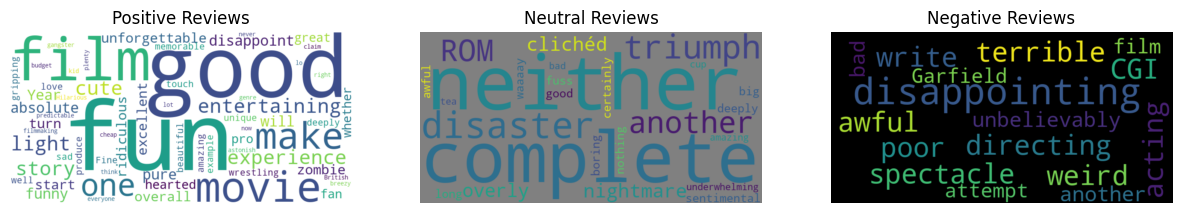

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds
positive_reviews = ' '.join(df_exploded[df_exploded['sentiment'] == 2]['processed_reviews'])
neutral_reviews = ' '.join(df_exploded[df_exploded['sentiment'] == 0]['processed_reviews'])
negative_reviews = ' '.join(df_exploded[df_exploded['sentiment'] == 1]['processed_reviews'])

# Check the lengths of the review strings
print(f'Length of positive reviews: {len(positive_reviews)}')
print(f'Length of neutral reviews: {len(neutral_reviews)}')
print(f'Length of negative reviews: {len(negative_reviews)}')

# Generate word clouds only if there are words in the reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews) if len(positive_reviews) > 0 else None
neutral_wordcloud = WordCloud(width=800, height=400, background_color='gray').generate(neutral_reviews) if len(neutral_reviews) > 0 else None
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews) if len(negative_reviews) > 0 else None

plt.figure(figsize=(15, 5))

if positive_wordcloud:
    plt.subplot(1, 3, 1)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Positive Reviews')
    plt.axis('off')

if neutral_wordcloud:
    plt.subplot(1, 3, 2)
    plt.imshow(neutral_wordcloud, interpolation='bilinear')
    plt.title('Neutral Reviews')
    plt.axis('off')

if negative_wordcloud:
    plt.subplot(1, 3, 3)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Negative Reviews')
    plt.axis('off')

plt.show()


## Converting ipynb to html

In [10]:
import nbconvert
import nbformat

notebook_filename = 'semestralka.ipynb'

# Read the notebook
with open(notebook_filename) as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert the notebook to HTML
html_exporter = nbconvert.HTMLExporter()
html_content, resources = html_exporter.from_notebook_node(notebook_content)

# Write the HTML output to a file
with open('sentiment_analysis.html', 'w') as f:
    f.write(html_content)
